# FIFA 18


This dataset contains the attribute of players in fifa 18. Also the countries and respective clubs of the players.
In this notebook, we explore the data set inorder to derive insights from it and later predict the value of a player based on these attributes.


In [17]:
import pandas as pd
import warnings
warnings.simplefilter('ignore')
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV  
from sklearn import metrics
from pylab import rcParams
from collections import Counter, defaultdict
sns.set(style="white", palette="muted", color_codes=True)
%matplotlib inline

# Loading The Dataset

In [18]:
player_attribute = pd.read_csv("PlayerAttributeData.csv", index_col=0)
player_personal = pd.read_csv("PlayerPersonalData.csv", index_col=0)

Let's deal with the Player's Personal details first.

In [3]:
player_personal.head(2)

,Unnamed: 0.1,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special
0,0,20801,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€95.5M,€565K,2228
1,1,158023,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€105M,€565K,2154


Let's take a look at the number of players coming from each country.

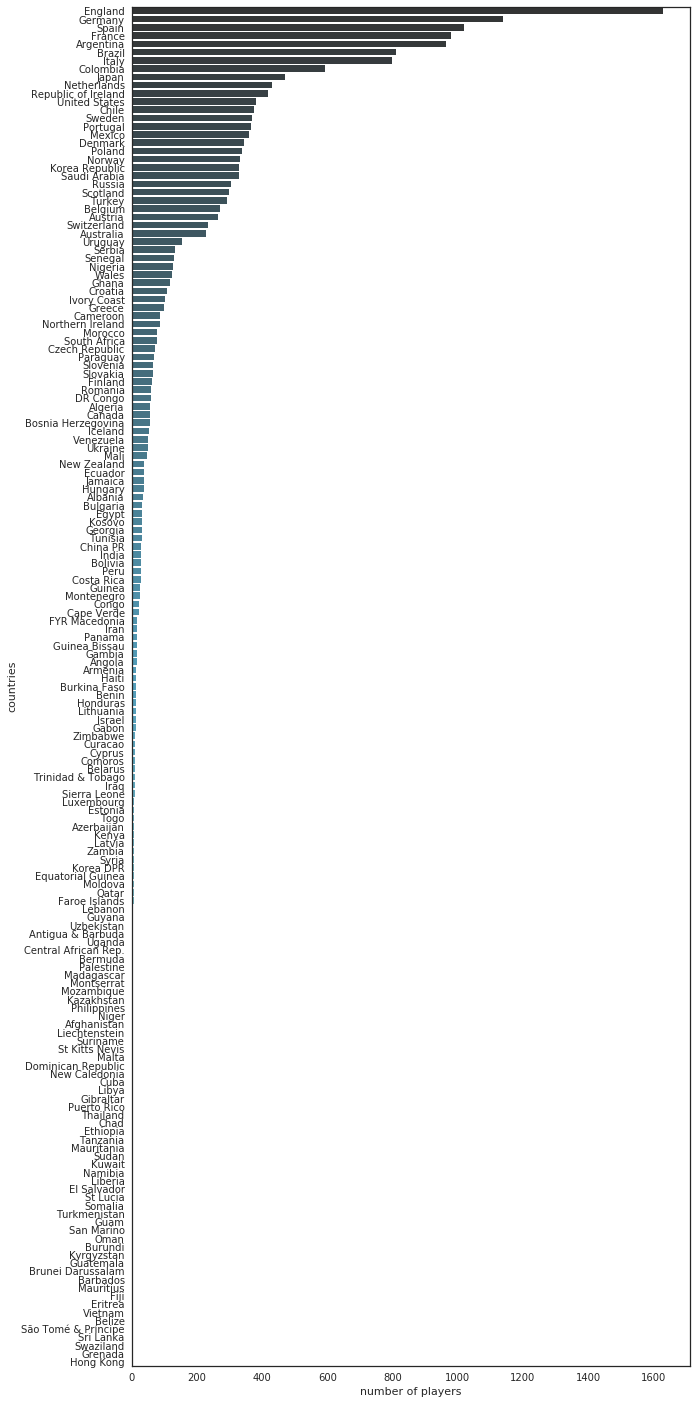

In [10]:
f, ax = plt.subplots(figsize=(10, 25))
countries = Counter(player_personal["Nationality"])
Nations_to_players = defaultdict(list)
for c in countries:
    Nations_to_players["countries"].append(c)
    Nations_to_players["number of players"].append(countries[c])
countries_to_num = pd.DataFrame(Nations_to_players)
countries_to_num = countries_to_num.sort_values("number of players", ascending=False)
sns.barplot(y="countries", x="number of players", data = countries_to_num, palette="GnBu_d")

In [11]:
countries_to_num["number of players"].sum()

17981

We can see that more players coming from England, Germany, Spain and France. You'll also see that the top 5 countries contribute approximately 32 percent of the players in the world

Let's also take a look at the number of players in each club.

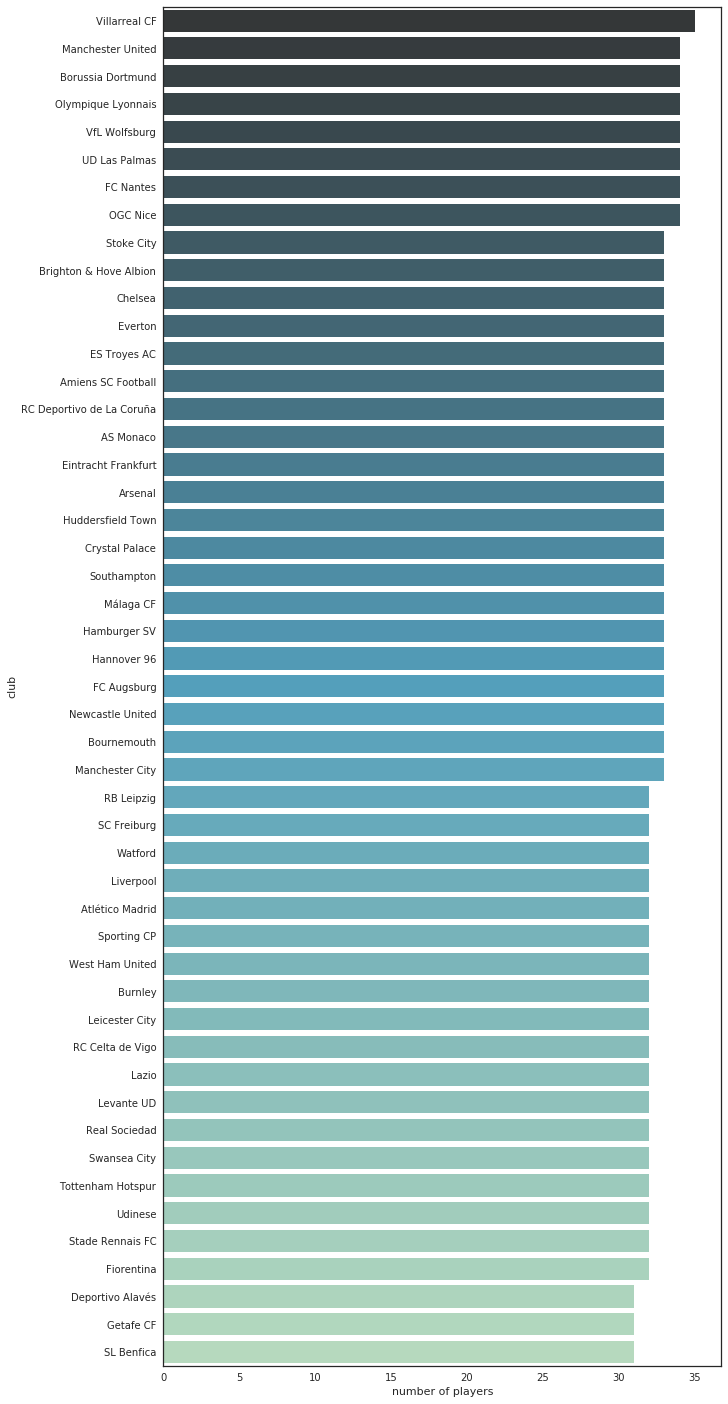

In [12]:
f, ax = plt.subplots(figsize=(10, 25))
club = Counter(player_personal["Club"])
club_to_players = defaultdict(list)
for c in club:
    club_to_players["club"].append(c)
    club_to_players["number of players"].append(club[c])
club_to_num = pd.DataFrame(club_to_players)
club_to_num = club_to_num.sort_values("number of players", ascending=False)
sns.barplot(y="club", x="number of players", data= club_to_num.head(50), palette="GnBu_d")

We can also the the fairness in the distribution of players in each football club. This might be due to the fact that most players coming from a country playing for a football club do not necessary play for their country. Therefore we can see high number of players coming from a country.
Or There might be a Cap on the number of players allowed in club maybe be the Football Association of the Country or the Club's policy.

Let's take a look at the age, potential,value and wage distribution of players in the world

In [13]:
#Convert the values in the column Value and Wage into a usable form i.e String.
def convert_to_int(x):
    remove = "K€M"
    for i in remove:
        x = x.replace(i,"")
    return x
player_personal["Wage"] = player_personal["Wage"].apply(lambda x: convert_to_int(x))
player_personal["Value"] = player_personal["Value"].apply(lambda x: convert_to_int(x))
player_personal[["Value","Wage"]] = player_personal[["Value","Wage"]].astype(float)

player_personal.head(1)

,Unnamed: 0.1,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special
0,0,20801,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,95.5,565.0,2228


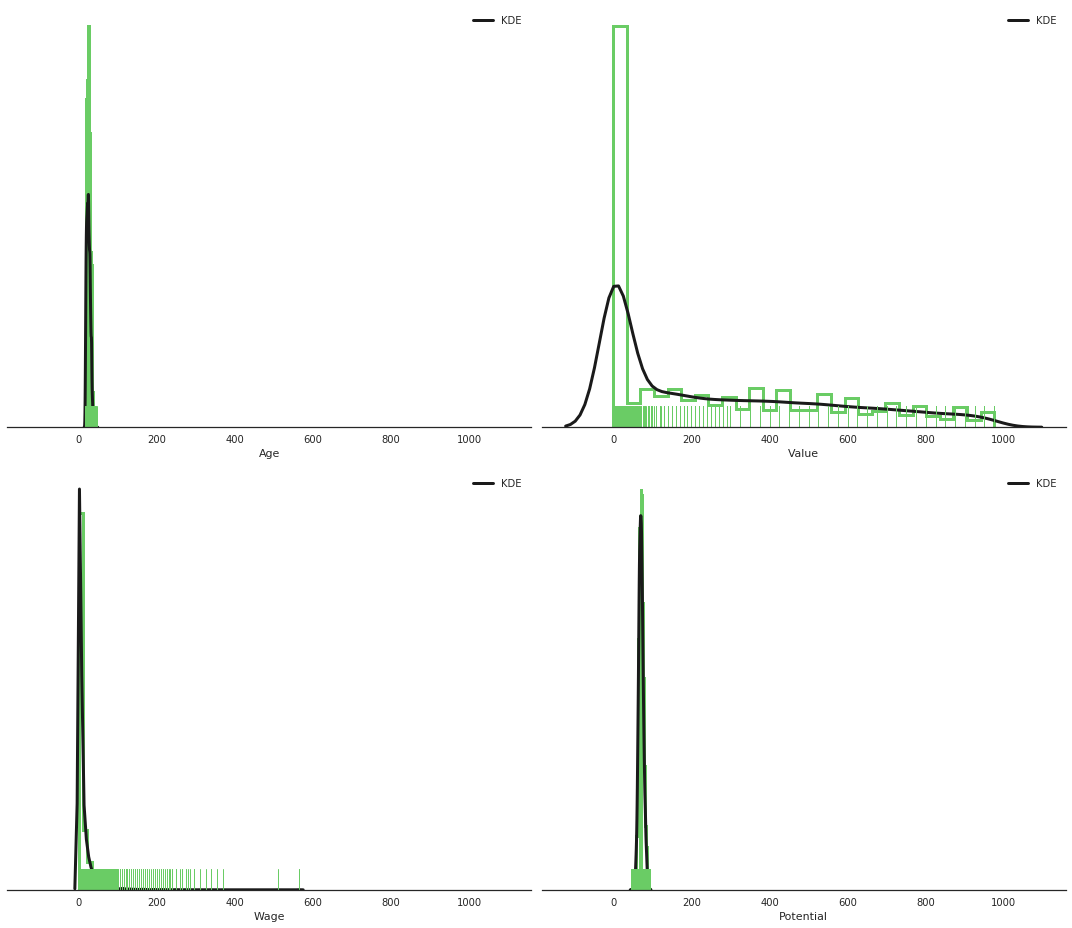

In [14]:
f, axes = plt.subplots(2, 2, figsize=(15, 13), sharex=True)
sns.despine(left=True)
sns.distplot(player_personal.Age, rug=True, rug_kws={"color": "g"},
            kde_kws={"color": "k", "lw": 3, "label": "KDE"},
            hist_kws={"histtype": "step", "linewidth": 3,
            "alpha": 1, "color": "g"},ax=axes[0, 0])
sns.distplot(player_personal.Value, rug=True, rug_kws={"color": "g"},
            kde_kws={"color": "k", "lw": 3, "label": "KDE"},
            hist_kws={"histtype": "step", "linewidth": 3,
            "alpha": 1, "color": "g"},ax=axes[0, 1])
sns.distplot(player_personal.Wage, rug=True, rug_kws={"color": "g"},
            kde_kws={"color": "k", "lw": 3, "label": "KDE"},
            hist_kws={"histtype": "step", "linewidth": 3,
            "alpha": 1, "color": "g"},ax=axes[1, 0])
sns.distplot(player_personal.Potential, rug=True, rug_kws={"color": "g"},
            kde_kws={"color": "k", "lw": 3, "label": "KDE"},
            hist_kws={"histtype": "step", "linewidth": 3,
            "alpha": 1, "color": "g"},ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

There are players recieving high amount of wages. The Potential of players can be said to be normaly distributed so also the ages.

Let's take a look at the correlation among the Potential, Value, Age and Wage of players.

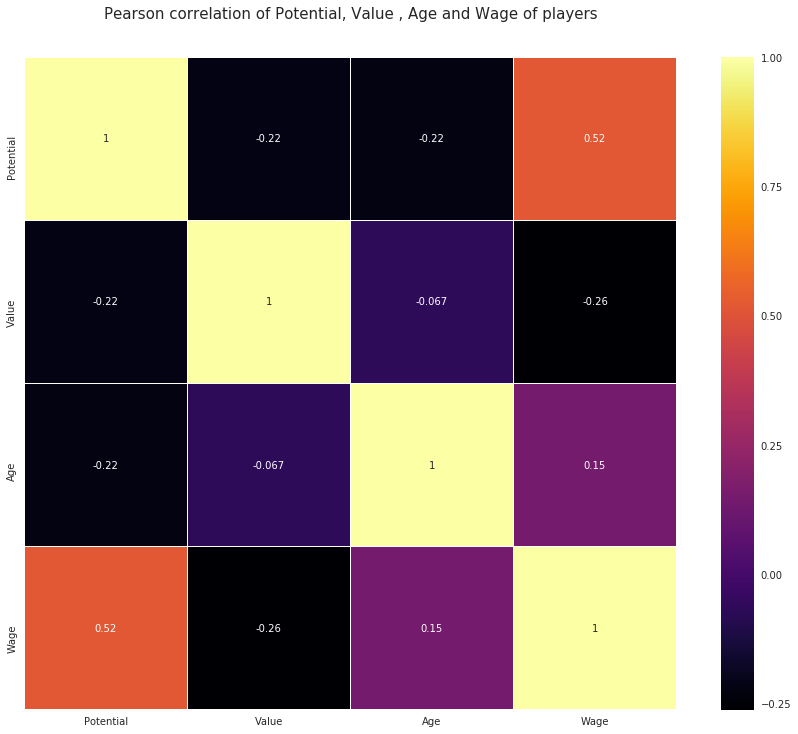

In [16]:
corr_variables = player_personal[["Potential", "Value","Age", "Wage"]]
colormap = plt.cm.inferno
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of Potential, Value , Age and Wage of players', 
          y=1.05, size=15)
sns.heatmap(corr_variables.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

We can see that there is a positive correlation between the wage of a player and their potential i.e the Wage of a player is well influenced by the potential of the player.
We can also infere that the Age of player has no effect on the Value of the player and even Slightly negatively correlated to the potential. This can be seen in the World of Football today, where young players like Pogba are being bought for very high amount, also Neymer with a huge amount of Wages.

We could also have a good look into each continents.

# Let's Load a csv file containing the Countries and their respective continents

In [35]:
continent_countries = pd.read_csv("countries and continents.csv")[["name","Continent"]]
continent_countries.dropna(inplace=True)

In [36]:
continent_countries["Nationality"] = continent_countries["name"]
continent_countries.drop("name",1, inplace=True)

In [56]:
#We merge it with other dataset.
cont_player_personal = pd.merge(player_personal, continent_countries,on = "Nationality", how='left')
cont_player_personal["countries"] = cont_player_personal["Nationality"]
cont_player_personal.drop("Nationality",1, inplace=True)
cont_player_personal = pd.merge(cont_player_personal, countries_to_num,on = "countries", how='left')

In [59]:
cont_player_personal.dropna(inplace=True)
cont_player_personal.head(2)

,Unnamed: 0.1,ID,Name,Age,Photo,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Continent,countries,number of players
0,0,20801,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,95.5,565.0,2228,EU,Portugal,367
1,1,158023,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,105.0,565.0,2154,SA,Argentina,965


In [61]:
group_cont = cont_player_personal.groupby("Continent", as_index=False).agg({"Age": lambda x: x.sum()/len(x),
                                                             "number of players": lambda x: x.sum()/len(x),
                                                             "Wage": lambda x: x.sum()/len(x),
                                                             "Value": lambda x: x.sum()/len(x),
                                                             "Potential": lambda x: x.sum()/len(x)})

In [63]:
group_cont

,Continent,Wage,Age,Value,Potential,number of players
0,AF,12.853125,24.838542,254.704271,72.664583,76.960417
1,AS,7.900327,25.706699,276.218219,67.757353,338.874183
2,EU,12.937947,24.816062,265.030743,72.119541,627.862201
3,OC,4.619231,24.330769,316.885769,68.423077,200.269231
4,SA,12.897267,26.473494,234.417419,72.152453,693.733289


In [65]:
group_cont = pd.melt(group_cont, id_vars=["Continent"]).sort_values(['variable','value'])

Text(0.5,1,'Variation of Wages, Age, Value, Potential and Number of players in Different Contitents')

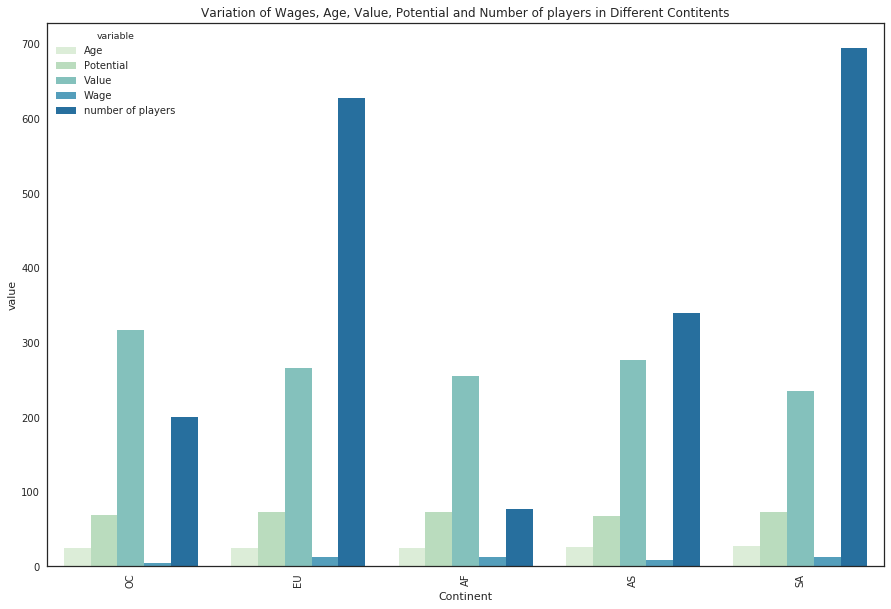

In [70]:
rcParams['figure.figsize'] = 15,10

sns.barplot(x='Continent', y='value', hue='variable', data=group_cont, palette="GnBu")
plt.xticks(rotation=90)
plt.title('Variation of Wages, Age, Value, Potential and Number of players in Different Contitents')

We can see from the plot that Oceania has the lowest in all the variables followed by Africa.
It's obvious now that South America have alot of intrest in football.

# Diving The Complete Dataset

In [19]:
fifa_df = pd.read_csv("CompleteDataset.csv", index_col=0)


In [20]:
#Converted the value and wage column into integer
def convert_to_int(x):
    remove = "K€M"
    for i in remove:
        x = x.replace(i,"")
    return x
fifa_df["Wage"] = fifa_df["Wage"].apply(lambda x: convert_to_int(x))
fifa_df["Value"] = fifa_df["Value"].apply(lambda x: convert_to_int(x))
fifa_df[["Value","Wage"]] = fifa_df[["Value","Wage"]].astype(float)

fifa_df.tail(1)

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys
17980,L. Sackey,18,https://cdn.sofifa.org/48/18/players/238308.png,Ghana,https://cdn.sofifa.org/flags/117.png,46,64,Scunthorpe United,https://cdn.sofifa.org/24/18/teams/1949.png,50.0,...,40,31,21,43,49,55,44,67,22,19


In [21]:
fifa_df.drop(["Photo", "Flag","Club Logo","Name"],1,inplace=True)

In [22]:
fifa_df.drop("ID",1,inplace=True)

In [23]:
l_encode = LabelEncoder()
obj_feat = ["Club", "Nationality"]
for var in obj_feat:
    fifa_df[var] = l_encode.fit_transform(fifa_df[var].astype(str))
fifa_df.shape

(17981, 42)

In [24]:
fifa_df.dtypes

Age                     int64
Nationality             int64
Overall                 int64
Potential               int64
Club                    int64
Value                 float64
Wage                  float64
Special                 int64
Acceleration           object
Aggression             object
Agility                object
Balance                object
Ball control           object
Composure              object
Crossing               object
Curve                  object
Dribbling              object
Finishing              object
Free kick accuracy     object
GK diving              object
GK handling            object
GK kicking             object
GK positioning         object
GK reflexes            object
Heading accuracy       object
Interceptions          object
Jumping                object
Long passing           object
Long shots             object
Marking                object
Penalties              object
Positioning            object
Reactions              object
Short pass

In [25]:
# Clean the Object values in the data frame, discovered there was "67 + 3" in the dataset
def clean_values(x):
    try:
        if len(x)>2:
            y = x[:2]
            return y
        else:
            return x
    except TypeError:
        return x
fifa_df["Acceleration"] = fifa_df["Acceleration"].apply(lambda x:clean_values(x))
fifa_df["Curve"] = fifa_df["Curve"].apply(lambda x:clean_values(x))
fifa_df["Dribbling"] = fifa_df["Dribbling"].apply(lambda x:clean_values(x))
fifa_df["Finishing"] = fifa_df["Finishing"].apply(lambda x:clean_values(x))
fifa_df["Free kick accuracy"] = fifa_df["Free kick accuracy"].apply(lambda x:clean_values(x))
fifa_df["GK diving"] = fifa_df["GK diving"].apply(lambda x:clean_values(x))
fifa_df["GK handling"] = fifa_df["GK handling"].apply(lambda x:clean_values(x))
fifa_df["GK kicking"] = fifa_df["GK kicking"].apply(lambda x:clean_values(x))
fifa_df["GK positioning"] = fifa_df["GK positioning"].apply(lambda x:clean_values(x))
fifa_df["GK reflexes"] = fifa_df["GK reflexes"].apply(lambda x:clean_values(x))
fifa_df["Heading accuracy"] = fifa_df["Heading accuracy"].apply(lambda x:clean_values(x))
fifa_df["Interceptions"] = fifa_df["Interceptions"].apply(lambda x:clean_values(x))
fifa_df["Jumping"] = fifa_df["Jumping"].apply(lambda x:clean_values(x))
fifa_df["Long passing"] = fifa_df["Long passing"].apply(lambda x:clean_values(x))
fifa_df["Long shots"] = fifa_df["Long shots"].apply(lambda x:clean_values(x))
fifa_df["Marking"] = fifa_df["Marking"].apply(lambda x:clean_values(x))
fifa_df["Penalties"] = fifa_df["Penalties"].apply(lambda x:clean_values(x))
fifa_df["Positioning"] = fifa_df["Positioning"].apply(lambda x:clean_values(x))
fifa_df["Reactions"] = fifa_df["Reactions"].apply(lambda x:clean_values(x))
fifa_df["Short passing"] = fifa_df["Short passing"].apply(lambda x:clean_values(x))
fifa_df["Shot power"] = fifa_df["Shot power"].apply(lambda x:clean_values(x))
fifa_df["Sliding tackle"] = fifa_df["Sliding tackle"].apply(lambda x:clean_values(x))
fifa_df["Sprint speed"] = fifa_df["Sprint speed"].apply(lambda x:clean_values(x))
fifa_df["Stamina"] = fifa_df["Stamina"].apply(lambda x:clean_values(x))
fifa_df["Standing tackle"] = fifa_df["Standing tackle"].apply(lambda x:clean_values(x))
fifa_df["Strength"] = fifa_df["Strength"].apply(lambda x:clean_values(x))
fifa_df["Vision"] = fifa_df["Vision"].apply(lambda x:clean_values(x))
fifa_df["Volleys"] = fifa_df["Volleys"].apply(lambda x:clean_values(x))
fifa_df["Crossing"] = fifa_df["Crossing"].apply(lambda x:clean_values(x))
fifa_df["Composure"] = fifa_df["Composure"].apply(lambda x:clean_values(x))
fifa_df["Ball control"] = fifa_df["Ball control"].apply(lambda x:clean_values(x))
fifa_df["Balance"] = fifa_df["Balance"].apply(lambda x:clean_values(x))
fifa_df["Aggression"] = fifa_df["Aggression"].apply(lambda x:clean_values(x))
fifa_df["Agility"] = fifa_df["Agility"].apply(lambda x:clean_values(x))


In [26]:
#Converted all the features to float.
fifa_df.astype(float)
fifa_df.tail(4)

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Acceleration,Aggression,...,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys
17977,47,45,46,46,636,0.0,1.0,832,25,44,...,51,12,13,13,25,32,12,47,17,12
17978,17,129,46,61,567,60.0,1.0,1194,66,26,...,54,42,42,14,51,33,17,32,37,33
17979,18,45,46,64,174,60.0,1.0,1302,57,46,...,49,49,43,47,58,49,48,46,51,25
17980,18,59,46,64,526,50.0,1.0,1031,48,52,...,40,31,21,43,49,55,44,67,22,19


# WE ARE GOING TO PREDICT THE VALUE OF A PLAYER BASED.

I'll be using mean squared error as my evaluation metric. Also I'll be implementing Gradient Boosting Regressor Algorithm

In [27]:
def modelfit(alg, dtrain, features, performCV=True, printFeatureImportance=True, cv_folds=10):
    #Fit the algorithm on the data
    alg.fit(dtrain[features],dtrain["Value"] )
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[features])

    #Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, dtrain[features], dtrain["Value"], cv=cv_folds,
                                                scoring='mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain["Value"], dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),
                                                                             np.std(cv_score),np.min(cv_score),
                                                                              np.max(cv_score)))
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, features).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
RMSE : 138.3
CV Score : Mean - 144.4 | Std - 87.79 | Min - 46.27 | Max - 316.4


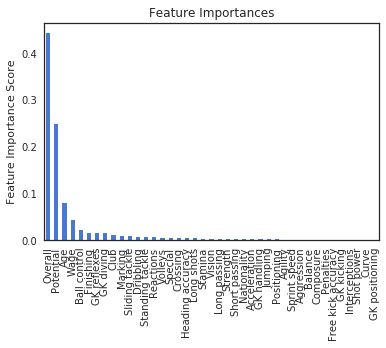

In [35]:
features = [i for i in fifa_df.columns if i != "Value"]
target = "Value"
gbm0 = GradientBoostingRegressor(random_state=7)
modelfit(gbm0, fifa_df, features)


In [36]:
estimators = [x for x in range(1,100,10)]


param_test1 = {'n_estimators':estimators}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='mean_squared_error',n_jobs=4,iid=False, cv=10)
gsearch1.fit(fifa_df[features],fifa_df["Value"])

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -86224.35246, std: 56114.22340, params: {'n_estimators': 1},
  mean: -48419.37386, std: 42246.44651, params: {'n_estimators': 11},
  mean: -39031.29983, std: 38595.30272, params: {'n_estimators': 21},
  mean: -34076.97518, std: 35041.22442, params: {'n_estimators': 31},
  mean: -32214.66072, std: 33569.94043, params: {'n_estimators': 41},
  mean: -30591.12825, std: 32284.56248, params: {'n_estimators': 51},
  mean: -30094.55544, std: 31648.34007, params: {'n_estimators': 61},
  mean: -29684.30269, std: 31257.57822, params: {'n_estimators': 71},
  mean: -29412.68467, std: 30750.85154, params: {'n_estimators': 81},
  mean: -29096.57423, std: 30475.15736, params: {'n_estimators': 91}],
 {'n_estimators': 91},
 -29096.57423019868)


Model Report
RMSE : 127.4
CV Score : Mean - 146.9 | Std - 86.76 | Min - 49.31 | Max - 301.4


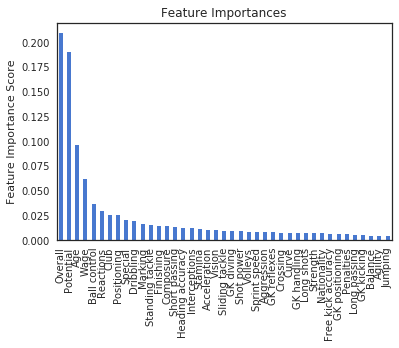

In [37]:
modelfit(gsearch1.best_estimator_, fifa_df, features)

We could go on tuning the parameters. 